# F04 - Visual Analysis of Moving Vehicles



Eugeniu Ostrovan \\
Federico Innocente \\
Andrea Marcer 

# Imports

In [1]:
import numpy as np
import cv2 as cv2
import os
import collections
import math

from matplotlib import pyplot as plt

%matplotlib inline
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

In [3]:
def fixColor(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def show(image):
  plt.figure()
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

# Video Processing: Car Detection

Process video frames to create the foreground masks. We use a mixure of gaussians background subtractor, than we process the result to reduce the noise and fill holes. 

In [11]:
def wrapper_for_background_subtraction(video_path):

  masks = []
  frames = []

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
  gradient_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  gradient_kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))

  backSub = cv2.createBackgroundSubtractorMOG2()
  capture = cv2.VideoCapture(video_path)
  if not capture.isOpened():
      print('Unable to open video')
  frame_cnt = 0

# Read frames and apply background subtraction
# Save frames and masks in lists
  while True:
      frame_cnt += 1
      if frame_cnt % 100  == 0:
        print('reading frame ', frame_cnt)

      ret, frame = capture.read()
      if frame is None:
          break
      frames.append(frame)
      frame = cv2.GaussianBlur(frame,(5,5),0)
      foregroundMask = backSub.apply(frame)
      masks.append(foregroundMask)

# Process the masks to reduce noise and fill holes
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))

  processed_masks = []
  threshold_value = 150
  frame_cnt = 0
  
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
  grad_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
  for mask in masks:
    frame_cnt += 1
    if frame_cnt % 100 == 0:
      print(frame_cnt)
    gauss = cv2.GaussianBlur(mask.copy(),(9,9),0)
    threshold = cv2.threshold(gauss, threshold_value, 255, cv2.THRESH_BINARY)
    threshold = threshold[1]
    closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)

    gradient = cv2.morphologyEx(closing, cv2.MORPH_GRADIENT, grad_kernel)

    thresh = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
    thresh = thresh[1]
    flood = cv2.floodFill(thresh, None, (0,0), 255)
    flood = flood[1]
    invert = cv2.bitwise_not(flood)
    combine = gradient | invert

    gradient = cv2.morphologyEx(combine, cv2.MORPH_GRADIENT, kernel)
    final = cv2.bitwise_and(combine, cv2.bitwise_not(gradient))
    processed_masks.append(final)

  return frames, processed_masks

Capture the video and call the frame processing to create masks

In [5]:
################################################################################

# Insert here the video path
video_path = './Input_video.mp4'

################################################################################

In [12]:
masks = []
frames = []

input_cap = cv2.VideoCapture(video_path)
if not input_cap.isOpened():
    print('Unable to open video')

frames, masks = wrapper_for_background_subtraction(video_path)

reading frame  100
reading frame  200
reading frame  300
reading frame  400
reading frame  500
reading frame  600
reading frame  700
reading frame  800
reading frame  900
reading frame  1000
reading frame  1100
100
200
300
400
500
600
700
800
900
1000
1100


# Distance estimation

Compute the distance of a point on the street plane from the image plane 

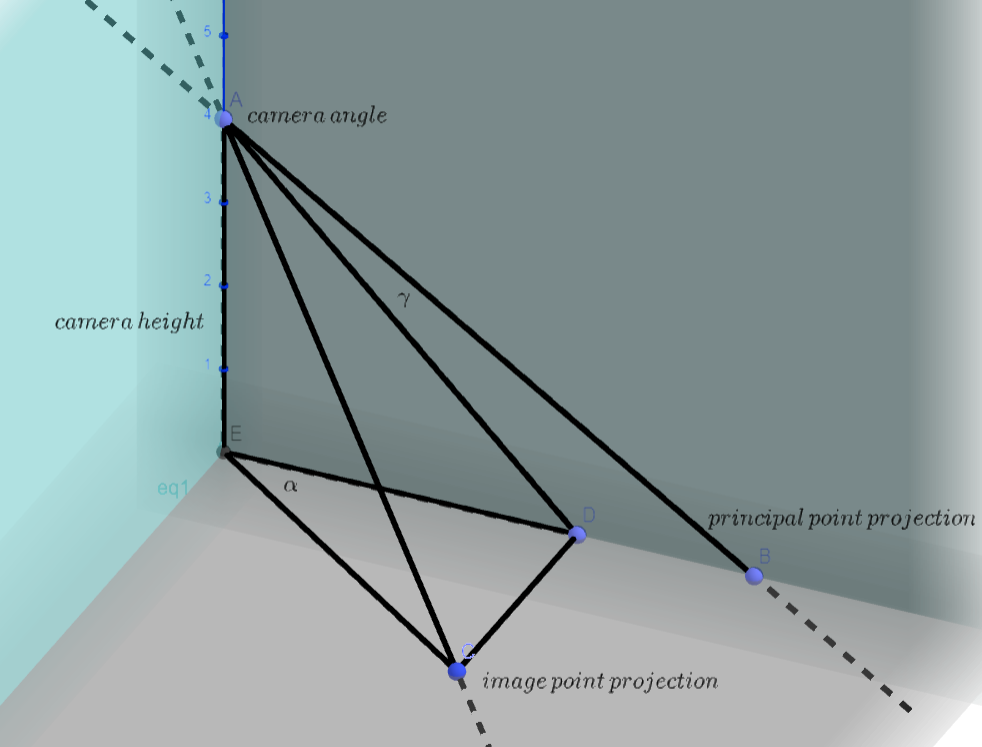

In [13]:
def calc_gamma(principal_point_y, image_point_y, f):
  #the angle of the ray defined by the image point wrt camera height
  gamma = math.asin((principal_point_y - image_point_y) / (math.sqrt(f**2 + (principal_point_y - image_point_y)**2)))
  gamma = (gamma / math.pi) * 180
  return gamma

#camera angle wrt to the height of the camera
def calc_camera_angle(height, base):
  #camera distance from road along principal axis
  ipo = math.sqrt(base**2 + height**2)#meters
  #camera inclication wrt road plane
  camera_angle = math.acos(height / ipo)
  camera_angle = (camera_angle / math.pi) * 180
  return camera_angle

# Z is the the distance AD of the image
def calc_z(camera_angle, gamma, height):
  alpha = camera_angle + gamma #in degrees
  # print('alpha ', alpha)
  alpha = alpha /180 * math.pi
  Z = height / math.cos(alpha)
  return Z

#alpha is the angle between the image ray of the image point projected on the O plane and the original ray
def calc_alpha(principal_point_x, image_point_x, f):
  delta_x = principal_point_x - image_point_x
  tan_alpha = delta_x / f
  alpha = math.atan(tan_alpha) # radians
  alpha = alpha / math.pi * 180 # degrees
  # print(delta_x, alpha)
  return alpha

# z_prime is the distance AC in the image
def calc_z_prime(z, alpha):
  alpha = alpha / 180 * math.pi
  z_prime = z / math.cos(alpha)
  return z_prime

# distance is the distance CE in the image
def calc_distance(z_prime, camera_angle):
  delta = 90 - camera_angle #camera angle should be in degrees, here delta is in degrees as well
  delta = delta / 180 * math.pi #convert to radians
  distance = z_prime / math.cos(delta) #in meters
  return distance

# Car Tracking and Speed Estimation

Class to model a vehicle: it contains information about features, car position in the image, vanishing points, trajectory, time to impact, distance and speed 

In [18]:
class Car:
  def __init__(self, window, frame, offset = 30, feature_history_len = 20, vanishing_history_len = 12, speed_history_len = 3):
    # window = (x,y,w,h)
    self.window = window
    self.offset = offset

    self.speed = collections.deque(maxlen = speed_history_len)
    self.vanishing_points = collections.deque(maxlen = vanishing_history_len)
    self.pts = collections.deque(maxlen = feature_history_len)

    self.distances = 0

    # Detect features only in the window
    mask = np.zeros_like(frame)
    mask[window[0]:window[0]+window[3], window[1]:window[1]+window[2]] = 255

    features = cv2.goodFeaturesToTrack(
        frame, 
        mask = mask,
        maxCorners = 10,
        qualityLevel = 0.2,
        minDistance = 30,
        blockSize = 15)
    self.pts.appendleft(features)

    if self.pts[0] is None:
      self.pts[0] = np.array([])

    
  def draw_features(self, frame):
    y,x,w,h = self.window
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    colors = [(0, 0, 255), (255, 0, 0), (0, 255, 0)]
    for i, feature_history in enumerate(self.pts):
      for point in feature_history:
        cv2.circle(frame, (point[0][0], point[0][1]), 1, colors[min(i, 2)], 2)

    if len(self.vanishing_points) > 0:
      vp = self.get_vanishing_point()
      cv2.circle(frame, (int(vp[0]), int(vp[1])), 1, (255,0,255), 4)
      cv2.circle(frame, (int(self.center[0]), int(self.center[1])), 1, (255,0,255), 4)
      cv2.line(frame, (int(self.center[0]), int(self.center[1])), (int(vp[0]), int(vp[1])), (255,0,255), 2)

    if len(self.speed) > 0:
      speed = np.mean(self.speed)
      cv2.putText(frame, 'v: ' + str(speed)[0:5], (int(self.center[0] -50), int(self.center[1]-50)), 1, 2, (255,255,255), thickness = 3)
      cv2.putText(frame, 'tti: ' + str(self.time_to_impact)[0:5], (int(self.center[0]-50), int(self.center[1] - 75)), 1, 2, (255,255,255), thickness = 3)
      cv2.putText(frame, 'dist: ' + str(self.car_distance)[0:5], (int(self.center[0]-50), int(self.center[1] -100)), 1, 2, (255,255,255),  thickness = 3)
    return frame


  def check_same_car(self, new_window):

    self.found_feature = False
    for pt in self.pts[0]:
      if pt[0][1] > new_window[0] and pt[0][1] < new_window[0] + new_window[3] and pt[0][0] > new_window[1] and pt[0][0] < new_window[1] + new_window[2]:
        self.found_feature = True
        break
      
    return self.found_feature


  def update_feature(self, old_frame, new_frame, fps): 

    new_pts, st, _ = cv2.calcOpticalFlowPyrLK(old_frame, new_frame, self.pts[0], None)

    good_new = new_pts[st==1]
    good_old = self.pts[0][st==1]

    self.pts.appendleft( np.expand_dims(good_new, 1) )

    if self.pts[0].shape[0] != self.pts[1].shape[0]: # lost feature, car no more valid
      return False, None, None, None

    if self.pts[0].shape[0] > 1 and len(self.pts) >= 2: # if I have at least two features with a minimum history of 2
      self.update_vanishing_point()
      self.time_to_impact = self.compute_time_to_impact(fps)
      self.car_distance = self.compute_distance_to_image_plane()
      speed = self.car_distance / self.time_to_impact * 3.6
      self.speed.appendleft(speed)
      return True, self.car_distance, self.time_to_impact, np.mean(self.speed)


  def update_vanishing_point(self, K = 5):
    fitted_lines = []
    for point in range(self.pts[0].shape[0]):
      x = []
      y = []
      #for time in range(0, len(self.pts)):
      x.append(self.pts[0][point][0][0])
      y.append(self.pts[0][point][0][1])
      x.append(self.pts[min(len(self.pts)-1, K)][point][0][0])
      y.append(self.pts[min(len(self.pts)-1, K)][point][0][1])
      
      fitted_line = np.polyfit(x, y, 1)
      fitted_line = (fitted_line[0] / fitted_line[1], -1 / fitted_line[1], 1)

      fitted_lines.append(fitted_line)
    
    intersection_points = []
    for i in range(0, len(fitted_lines) - 1):
      for j in range(i + 1, len(fitted_lines)):
        intersection = np.cross(fitted_lines[i], fitted_lines[j])
        intersection = [intersection[0]/intersection[2], intersection[1]/intersection[2]]
        if self.window[1] > intersection[1]:
          intersection_points.append(intersection)
    
    if len(intersection_points) > 0:
      vanishing_point = np.median(intersection_points, 0)
      self.vanishing_points.appendleft(vanishing_point)
    else:
      self.vanishing_points.appendleft([100,1500])

  def get_vanishing_point(self):
    return np.mean(self.vanishing_points, 0)
    
  def compute_time_to_impact(self, fps, K=5):
    dt = 1 / fps * min(len(self.pts), K)

    vp = np.mean(self.vanishing_points, 0)
    
    tti = 0
    for i in range(0, len(self.pts[0])):
      x = (self.pts[0][i][0])
      x1 = (self.pts[min(len(self.pts)-1, K)][i][0])
      if x[1] < x1[1]:
        tti += dt * math.hypot(x1[0] - vp[0], x1[1] - vp[1]) / math.hypot(x[0] - x1[0] , x[1] - x1[1])
      else:
        tti += dt * math.hypot(x[0] - vp[0], x[1] - vp[1]) / math.hypot(x1[0] - x[0] , x1[1] - x[1])
    return tti / len(self.pts[0])
  
  def compute_distance_to_image_plane(self):
    image_point = (np.mean(self.pts[0], 0))
    self.center = image_point[0]
    gamma = calc_gamma(principal_point_y= PRINCIPAL_POINT_Y, image_point_y= image_point[0][1], f= f)
    camera_angle = calc_camera_angle(height= HEIGHT, base= BASE_DISTANCE)
    z = calc_z(camera_angle= camera_angle, gamma= gamma, height= HEIGHT)
    alpha = calc_alpha(principal_point_x= PRINCIPAL_POINT_X, image_point_x= image_point[0][0], f= f)
    z1 = calc_z_prime(z= z, alpha= alpha)
    return calc_distance(z_prime= z1, camera_angle= camera_angle) 

  def update_window(self, window):
    self.window = window

In [19]:
# Cheks if two windows overlaps

def check_same_window(window, new_window, threshold = 0.5):
    old_window = window

    intersection_window = (max(old_window[0],new_window[0]),
                           max(old_window[1],new_window[1]),
                           min(old_window[0] + old_window[2] , new_window[0] + new_window[2]),
                           min(old_window[1] + old_window[3] , new_window[1] + new_window[3]))
    
    if (new_window[0] > old_window[0] + old_window[2] or new_window[0] + new_window[2] < old_window[0]) or (new_window[1] > old_window[1] + old_window[3] or new_window[1] + new_window[3] < old_window[1]):
      intersection = 0 
    else:
      intersection = (intersection_window[2] - intersection_window[0]) * (intersection_window[3] - intersection_window[1])

    union = old_window[2] * old_window[3] + new_window[2] * new_window[3] - intersection

    is_same = intersection / union > threshold

    return is_same

In [23]:
################################################################################
save_path = './output_video.mp4'

window_offset = 5 # minimum distance to the border of the video for a window
min_features_to_create_car = 3 # minimum nuber of detected features to create a car
windows_max_ratio = 0.3 # windows with side ratio smaller than this one are discarded

fps = input_cap.get(5)

create_gif = False # create a list with all the compured frame
create_video = True # create a video
stop_early = False # stop the computation after 'stop_at' frames
stop_at = 260

# KNOWN INFORMATIONS
HEIGHT = 8.5 #meters
BASE_DISTANCE = 30 #meters
f = 1711.8 # cellulare di Eugeniu

PRINCIPAL_POINT_X = 960
PRINCIPAL_POINT_Y = 540
################################################################################

In [24]:
if create_video:
  writer = cv2.VideoWriter( 
      save_path , 
      cv2.VideoWriter_fourcc(*"MP4V"), 
      input_cap.get(5),
      (int(input_cap.get(3)), int(input_cap.get(4)))
  )

total_frames = len(frames)

gif = []
cars = []

frameCnt=0
while(frameCnt < total_frames-1):
    frame = frames[frameCnt].copy()
    video_frame = frame

    print('\nFRAME', frameCnt)
    print('Current cars: ', len(cars))
   
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cnts, _ = cv2.findContours(masks[frameCnt], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If two windows satisfy the following conditions, they are considered for a possible new car
    print('Possible windows:')
    possible_windows = []
    for cnt in cnts:
      x,y,w,h = cv2.boundingRect(cnt)
      if w*h > 1500 and h / w > windows_max_ratio and w / h > windows_max_ratio: # check dimention and more or less square 
        if x > window_offset and y > window_offset and y+h < frame.shape[0] and x+w < frame.shape[1]: # exclude border windows
          if x + w < 1299 and y > 230: # define ROI
            possible_windows.append((y,x,w,h))
            print('\t-', (y,x,w,h))
    
    # Cheks if there are overlapping windows and eliminate them
    print('Selected windows:')
    windows = []
    if len(possible_windows) > 0:
      windows.append(possible_windows[0])
      print('\t-', possible_windows[0])
    for new_window in possible_windows:
      check_same = False
      for detected_window in windows:
        if not check_same and check_same_window(detected_window, new_window):
          check_same = True
      if not check_same:
        windows.append(new_window)
        print('\t-', new_window)


    # Update the features of the already tracked cars
    print('Feature updating')
    for i, car in enumerate(cars):
      rtn, car_distance, time_to_impact, speed  = car.update_feature(old_gframe, gframe, fps)
      print('\t - car', i)
      if rtn:
        print('\t\t- Point history shape: ', car.pts[0].shape)
        print('\t\t- Vanishing', car.get_vanishing_point())
        print('\t\t- Car distance: ', car_distance)
        print('\t\t- TTI: ', time_to_impact)
        print('\t\t- Car speed: ', speed)

    detected_cars = []
    has_been_updated = np.zeros(len(cars))

    # Compare windows with already found cars
    for window in windows:
      x,y,w,h = window
      detected = False
      for i, car in enumerate(cars):
        print('car ', i, 'is in ', window)
        if car.check_same_car(window):
          detected = True
          if has_been_updated[i] == 0:
            print('\t added')
            car.update_window(window)
            car.draw_features(video_frame)
            detected_cars.append(car)
            has_been_updated[i] = 1
      if not detected:
        print('window ', window, ' is empty')
        new_car = Car((x,y,w,h), gframe)
        if new_car.pts[0].shape[0] >= min_features_to_create_car:
          print('\t added')
          detected_cars.append(new_car)

    cars = detected_cars

    old_gframe = gframe

    # Print the current frame and the number of cars currently tracked
    cv2.rectangle(video_frame, (40,40), (270, 160), (255,255,255), -1)
    cv2.putText(video_frame, str(frameCnt), (50, 100), 1, 4, (0,0,0))
    cv2.putText(video_frame, 'Cars:' + str(len(detected_cars)), (50, 150), 1, 4, (0,0,0))

    if create_gif: gif.append(frame)

    if stop_early and frameCnt > stop_at:
      break

    frameCnt+=1
    if create_video: writer.write(cv2.resize(frame, (int(input_cap.get(3)), int(input_cap.get(4)))))
 
#Release video object
if create_video: writer.release()

Output streaming troncato alle ultime 5000 righe.
	 added
car  1 is in  (622, 1025, 131, 135)
car  2 is in  (622, 1025, 131, 135)
car  0 is in  (415, 1032, 83, 85)
car  1 is in  (415, 1032, 83, 85)
	 added
car  2 is in  (415, 1032, 83, 85)
car  0 is in  (385, 1218, 58, 60)
car  1 is in  (385, 1218, 58, 60)
car  2 is in  (385, 1218, 58, 60)
	 added

FRAME 948
Current cars:  3
Possible windows:
	- (615, 1030, 130, 133)
	- (419, 1026, 85, 87)
	- (383, 1220, 57, 58)
Selected windows:
	- (615, 1030, 130, 133)
	- (419, 1026, 85, 87)
	- (383, 1220, 57, 58)
Feature updating
	 - car 0
		- Point history shape:  (8, 1, 2)
		- Vanishing [1331.7951634   159.44981621]
		- Car distance:  26.34486738675946
		- TTI:  2.042973896112088
		- Car speed:  47.03395256397946
	 - car 1
		- Point history shape:  (3, 1, 2)
		- Vanishing [1518.07429997   49.19938018]
		- Car distance:  39.68741357587262
		- TTI:  2.9400398871702307
		- Car speed:  48.610042099358004
	 - car 2
		- Point history shape:  (10, 1, 2)
